In [1]:
import keras as k
import keras.backend as K
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os 
import cv2
import pickle
from keras.utils import plot_model

In [2]:
path = 'E:\hackathon\\trainset\\'

In [3]:
def process_data(path):
    X_train = []
    train_labels = []
    for root, dirs, files in os.walk(path):
        for img_path in files:
            if img_path.endswith(".jpg"):
                img_abs_path = os.path.abspath(os.path.join(root, img_path))
                try:
                    image = cv2.imread(img_abs_path)
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    rez_img = cv2.resize(gray_image, (60, 60))
                    X_train.append(rez_img)
                    labelPath = os.path.split(img_abs_path)[0]
                    label = os.path.split(labelPath)[1]
                    train_labels.append(label)
                except:
                    print(img_abs_path,'image reading error')
    X_train = np.array(X_train)
    train_labels = np.array(train_labels)
    #X_train = np.expand_dims(X_train, axis=(-1))
    X_train = X_train.reshape(X_train.shape[0], 60, 60, 1)
    X_train = X_train.astype('float32')
    X_train /= 255
    
    return X_train,train_labels
                

In [4]:
(x_train_master, y_train_master) = process_data(path)

In [5]:
x_train_master.shape

(4993, 60, 60, 1)

In [8]:
y_train_master = y_train_master.flatten()

In [9]:
num_train_per_class = 5
n_epochs = 200

In [10]:
def generate_triplets(dataset, label, sample_per_class=10):
    x, y = None, None
    for i in os.listdir(path+'\\train'):
        pos_indices = np.argwhere(label == i)[:,0]
        neg_indices = np.argwhere(label != i)[:,0]

        # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
        choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
        choice_anchor = pos_indices[choice_anchor]

        choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
        choice_pos = pos_indices[choice_pos]

        choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=True)
        choice_neg = neg_indices[choice_neg]

        sub_x_anc = dataset[choice_anchor]
    
        sub_x_pos = dataset[choice_pos]

        sub_x_neg = dataset[choice_neg]
      
        
        if(x is None):
            x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
            y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
        else:
            x[0] = np.vstack((x[0], (sub_x_anc)))
            x[1] = np.vstack((x[1], (sub_x_pos)))
            x[2] = np.vstack((x[2], (sub_x_neg)))

            y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
            y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
            y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))

    return x, y

In [11]:
train_x, train_y = generate_triplets(x_train_master, y_train_master)

In [12]:
train_x[0].shape

(10120, 60, 60, 1)

In [13]:
def visualize_data(data, n):
  n = min(len(data[0]), n)
  random_choices = np.random.choice(len(data[0]),n, replace=False)
  fig, ax = plt.subplots(n, 3,figsize=(10,40))
  anc, pos, neg = data
  for i,ch in enumerate(random_choices):
    ax[i, 0].imshow(np.squeeze(anc[ch] ))
    ax[i, 1].imshow(np.squeeze(pos[ch] ))
    ax[i, 2].imshow(np.squeeze(neg[ch] ))
    

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].set_axis_off()

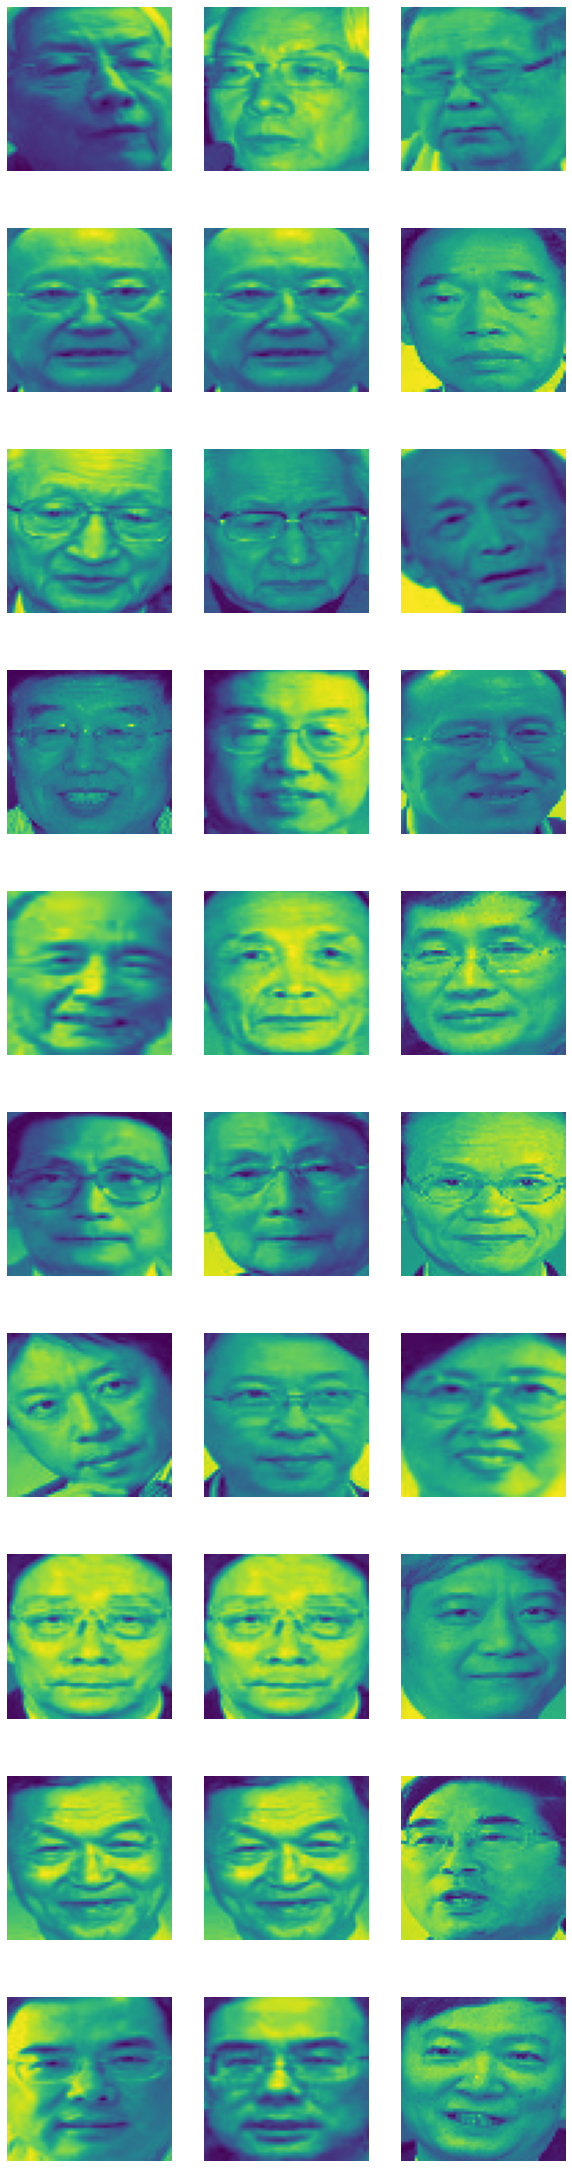

In [14]:
visualize_data(train_x, 10)

In [15]:
train_x, train_y = generate_triplets(x_train_master, y_train_master, num_train_per_class)
#test_x, test_y = generate_triplets(x_test_master, y_test_master,5)

In [16]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

def get_embedding_model(input_shape, embedding_dim):
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(embedding_dim * 8,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    return Model(_input, x)
        

def get_siamese_model(input_shape, triplet_margin=.3, embedding_dim=50):
    """
        Model architecture
    """
    
    # Define the tensors for the triplet of input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Convolutional Neural Network (same from earlier)
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    # Generate the embedding outputs 
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Connect the inputs with the outputs
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    
    siamese_triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    # return the model
    return embedding_model, siamese_triplet

# Siamese NN trained on all classes

In [17]:
def shuffle_triplets(inputs, labels):
  a, p, n = inputs
  l1, l2, l3 = labels
  randomizer = np.random.choice(a.shape[0], a.shape[0], replace=False)
  a = a[randomizer]
  p = p[randomizer]
  n = n[randomizer]

  l1 = l1[randomizer]
  l2 = l2[randomizer]
  l3 = l3[randomizer]
  return [a, p, n], [l1,l2,l3]

In [18]:
train_x, train_y = shuffle_triplets(train_x, train_y)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 60, 60, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 60, 60, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 60, 60, 1)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 150)          4726650     anchor_input[0][0]               
                                                                 positive_input[0][0]  

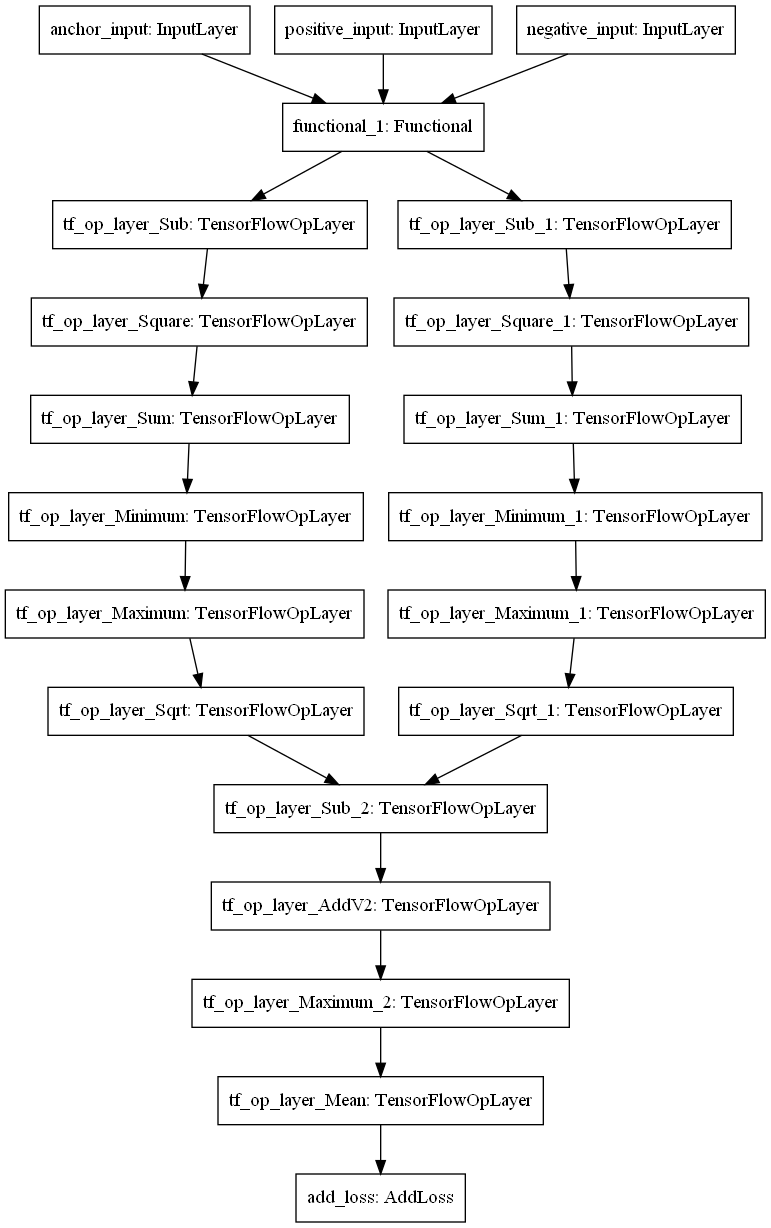

In [19]:
embedding_model2, siamese_triplet2 = get_siamese_model((60,60,1), triplet_margin=.3, embedding_dim=150)
siamese_triplet2.compile(loss=None, optimizer=Adam(0.0001))
siamese_triplet2.summary()
plot_model(siamese_triplet2,to_file='emb_trainer_model.png')

In [20]:
history_s2 = siamese_triplet2.fit(x=train_x, shuffle=True, batch_size=1000,
                              validation_split=.1, epochs=n_epochs)

Epoch 1/200
5/5 [==============================] - 0s 85ms/step - loss: 0.4889 - val_loss: 0.4528
Epoch 2/200
5/5 [==============================] - 0s 60ms/step - loss: 0.4016 - val_loss: 0.4052
Epoch 3/200
5/5 [==============================] - 0s 60ms/step - loss: 0.3565 - val_loss: 0.3808
Epoch 4/200
5/5 [==============================] - 0s 60ms/step - loss: 0.3308 - val_loss: 0.3682
Epoch 5/200
5/5 [==============================] - 0s 60ms/step - loss: 0.3095 - val_loss: 0.3535
Epoch 6/200
5/5 [==============================] - 0s 64ms/step - loss: 0.2954 - val_loss: 0.3476
Epoch 7/200
5/5 [==============================] - 0s 65ms/step - loss: 0.2711 - val_loss: 0.3399
Epoch 8/200
5/5 [==============================] - 0s 62ms/step - loss: 0.2568 - val_loss: 0.3353
Epoch 9/200
5/5 [==============================] - 0s 61ms/step - loss: 0.2416 - val_loss: 0.3243
Epoch 10/200
5/5 [==============================] - 0s 61ms/step - loss: 0.2352 - val_loss: 0.3169
Epoch 11/200
5/5 [=

Epoch 84/200
5/5 [==============================] - 0s 60ms/step - loss: 0.0012 - val_loss: 0.2500
Epoch 85/200
5/5 [==============================] - 0s 61ms/step - loss: 0.0012 - val_loss: 0.2486
Epoch 86/200
5/5 [==============================] - 0s 61ms/step - loss: 7.0649e-04 - val_loss: 0.2466
Epoch 87/200
5/5 [==============================] - 0s 62ms/step - loss: 6.4230e-04 - val_loss: 0.2471
Epoch 88/200
5/5 [==============================] - 0s 62ms/step - loss: 4.2910e-04 - val_loss: 0.2426
Epoch 89/200
5/5 [==============================] - 0s 61ms/step - loss: 3.3149e-04 - val_loss: 0.2388
Epoch 90/200
5/5 [==============================] - 0s 62ms/step - loss: 3.5812e-04 - val_loss: 0.2403
Epoch 91/200
5/5 [==============================] - 0s 61ms/step - loss: 2.4197e-04 - val_loss: 0.2384
Epoch 92/200
5/5 [==============================] - 0s 62ms/step - loss: 1.2060e-04 - val_loss: 0.2394
Epoch 93/200
5/5 [==============================] - 0s 62ms/step - loss: 1.1664e-

5/5 [==============================] - 0s 62ms/step - loss: 1.7809e-04 - val_loss: 0.2471
Epoch 164/200
5/5 [==============================] - 0s 60ms/step - loss: 1.7312e-04 - val_loss: 0.2447
Epoch 165/200
5/5 [==============================] - 0s 61ms/step - loss: 1.7448e-04 - val_loss: 0.2441
Epoch 166/200
5/5 [==============================] - 0s 63ms/step - loss: 1.1835e-04 - val_loss: 0.2548
Epoch 167/200
5/5 [==============================] - 0s 61ms/step - loss: 1.5458e-04 - val_loss: 0.2475
Epoch 168/200
5/5 [==============================] - 0s 60ms/step - loss: 2.6567e-04 - val_loss: 0.2480
Epoch 169/200
5/5 [==============================] - 0s 64ms/step - loss: 3.5827e-04 - val_loss: 0.2479
Epoch 170/200
5/5 [==============================] - 0s 60ms/step - loss: 2.7366e-04 - val_loss: 0.2456
Epoch 171/200
5/5 [==============================] - 0s 60ms/step - loss: 4.1811e-04 - val_loss: 0.2411
Epoch 172/200
5/5 [==============================] - 0s 61ms/step - loss: 5.06

In [21]:
train_embeds = embedding_model2.predict(np.vstack((train_x[0], train_x[1], train_x[2])))

In [22]:
target = np.hstack((train_y[0], train_y[1], train_y[2]))

In [23]:
from sklearn.neighbors import KNeighborsClassifier
def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
    classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
    classifier.fit(img_encoding, img_class)
    return classifier

In [24]:
classifier2 = fit_nearest_neighbor(train_embeds, target)

In [25]:
e2 = embedding_model2.predict(x_train_master)
op2 = classifier2.predict(e2)

In [26]:
(np.where(y_train_master == op2))[0].shape[0] / y_train_master.shape[0]

0.871620268375726

In [27]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_train_master, op2)

In [28]:
mat

array([[4, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 6, 0],
       [0, 0, 0, ..., 0, 0, 3]], dtype=int64)

In [53]:
#save classsifier model
# Its important to use binary mode 
knnPickle = open('knnpickle_file', 'wb')
# source, destination 
pickle.dump(classifier2, knnPickle)

In [30]:
from keras.models import model_from_json

In [31]:
# serialize model to JSON
model_json = embedding_model2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
embedding_model2.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [37]:
def loadimage(path):
    img = []
    if path:
        image = cv2.imread(path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rez_img = cv2.resize(gray_image, (60, 60))
        img.append(rez_img)
    img = np.array(img)
    img = img.reshape(img.shape[0],60,60,1)
    img = img / 255
    return img

In [38]:
img = loadimage('E:\hackathon\\trainset\\train\\0001_0000262\\copy.jpg')
img.shape

(1, 60, 60, 1)

In [54]:
e2 = embedding_model.predict(img)
op = classifier2.predict(e2)
op

array(['0001_0000262'], dtype='<U12')